# Detecting SSE events in Japan using CNN

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

Import known SSE events

In [3]:
knownSSE = pd.read_csv("japanSEE/sloweqjapan2003-2022.csv", parse_dates={"date": ["year", "month", "day"]})
sortedSSE = knownSSE.sort_values(by="date").drop_duplicates()
startdate = sortedSSE.iloc[0]['date']
enddate = sortedSSE.iloc[sortedSSE.shape[0]-1]['date']
print("Known SSE start date: ", startdate)
print("Known SSE end date: ", enddate)
print("Numbers of SSE: ", sortedSSE.shape[0])

Known SSE start date:  2003-02-02 00:00:00
Known SSE end date:  2019-10-12 00:00:00
Numbers of SSE:  379


In [4]:
print(sortedSSE.head())


          date     lat        lon
159 2003-02-02  24.347  125.07300
578 2003-02-04  34.491  136.32300
577 2003-02-06  33.731  134.41701
831 2003-02-13  34.374  137.88200
801 2003-02-28  35.754  140.25800


Import station data

In [5]:
# Choose directory
directory_name = "./japandata"
files = os.listdir(directory_name)

# Process data
GNSSdata = []
stationnames = []

# data range to be used
dates = pd.date_range('2004-01-01', '2020-01-01')

stationsprocessed = 0
for filename in files:
    if filename.endswith(".res"):
        # read in file
        path = os.path.join(directory_name, filename)
        GNSSdataframe = pd.read_csv(path, delim_whitespace=True, header=None)

        # parse data
        GNSSdataframe.columns = ["date", "NS_displacement", "EW_displacement", "UD_displacement", "Length_change"]
        GNSSdataframe = GNSSdataframe.drop(columns=["Length_change"])
        GNSSdataframe["date"] = pd.to_datetime(GNSSdataframe["date"])
        GNSSdataframe = GNSSdataframe.set_index("date")

        # Remove double up indexes
        GNSSdataframe = GNSSdataframe.loc[~GNSSdataframe.index.duplicated(), :]

        # reindex to desired time period
        idx = pd.DatetimeIndex(dates)
        GNSSdataframe = GNSSdataframe.reindex(idx)

        # if the number of days missing is too large then drop
        missingdays = GNSSdataframe.shape[0] - GNSSdataframe.dropna().shape[0]
        if missingdays < 200:
            p = GNSSdataframe.interpolate()
            nullremaining = p.shape[0] - p.dropna().shape[0]
            if nullremaining == 0:
                stationsprocessed = stationsprocessed+1
                splitted = filename.split(".")
                stationnames.append(splitted[0])
                GNSSdata.append(p)

print("Stations in array: ", stationsprocessed)

Stations in array:  99


In [6]:
print(stationnames[0])
print(GNSSdata[0].head())

021018
            NS_displacement  EW_displacement  UD_displacement
2004-01-01          -0.0006           0.0202          -0.0023
2004-01-02          -0.0001           0.0213           0.0008
2004-01-03           0.0000           0.0199           0.0012
2004-01-04          -0.0009           0.0201           0.0027
2004-01-05          -0.0008           0.0197           0.0006


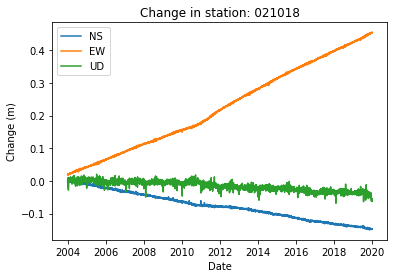

In [7]:
plt.plot(GNSSdata[0])
plt.xlabel("Date")
plt.ylabel("Change (m)")
plt.title("Change in station: " + stationnames[0])
plt.legend(["NS", "EW", "UD"])
plt.show();

Import station coordinates

In [8]:
# find directory
directory_name_cord = "./2019"
files_cord = os.listdir(directory_name_cord)

# Grab relevant files for usable stations
revl_files = []
revl_files_paths = []
for filename in files_cord:
    f_split = filename.split(".")

    if f_split[0] in stationnames:
        revl_files.append(f_split[0])
        path = os.path.join(directory_name_cord, filename)
        revl_files_paths.append(path)

    if "0" + f_split[0] in stationnames:
        revl_files.append("0" + f_split[0])
        path = os.path.join(directory_name_cord, filename)
        revl_files_paths.append(path)

print("Relevant files found: ", len(revl_files))
print("Stations coordinates not found: ", list(set(stationnames) - set(revl_files)))


Relevant files found:  99
Stations coordinates not found:  []


In [9]:
# station location is taken from 2019-01-01 and rounded to 4dp
stationarray = np.empty((0,3))
for i in range(0, len(revl_files)):
    opened_file = open(revl_files_paths[i])
    content = opened_file.readlines()
    line = content[20]
    line = line.split()
    lat = round(float(line[7]), 4)
    lon = round(float(line[8]), 4)
    stationarray = np.append(stationarray, np.array([[revl_files[i], lat, lon]]), axis=0)

stations_cord_df = pd.DataFrame(stationarray, columns=["station", "lat", "lon"])
stations_cord_df["lat"] = stations_cord_df["lat"].astype(float)
stations_cord_df["lon"] = stations_cord_df["lon"].astype(float)

print(stations_cord_df.head())

  station      lat       lon
0  020978  35.4866  135.7556
1  021082  32.8522  131.6292
2  021012  33.6688  135.8821
3  020999  34.4203  136.4745
4  021000  33.8770  135.9283


Plotting SSE's and Stations

In [10]:
BBox = ((stations_cord_df.lon.min(),   stations_cord_df.lon.max(),
         stations_cord_df.lat.min(), stations_cord_df.lat.max()))
print(BBox)

(130.2969, 138.5247, 32.7386, 36.1403)


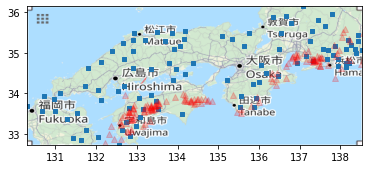

In [11]:
ruh_m = plt.imread('./japansection.png')
plt.scatter(stations_cord_df.lon, stations_cord_df.lat, zorder=1, marker='s', s=10)
plt.scatter(sortedSSE.lon, sortedSSE.lat, alpha=0.2, color='red', marker='^')
plt.xlim(BBox[0],BBox[1])
plt.ylim(BBox[2],BBox[3])
plt.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal');

We will use 10 stations from Uwajima to train the model since they are relatively close together and appear to have many SSE's in that area

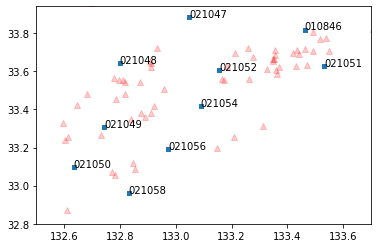

In [12]:
plt.scatter(stations_cord_df.lon, stations_cord_df.lat, zorder=1, marker='s', s=10)
for name in stationnames:
    plt.annotate(name, (stations_cord_df[stations_cord_df.station==name].lon, stations_cord_df[stations_cord_df.station==name].lat))
plt.scatter(sortedSSE.lon, sortedSSE.lat, alpha=0.2, color='red', marker='^')

# this is messy but used to find a SSE date close to a station
# for i in range(knownSSE.shape[0]):
#     plt.annotate(knownSSE.loc[i].date, (knownSSE.loc[i].lon, knownSSE.loc[i].lat),
#                  fontsize=6)
plt.xlim(132.5,133.7)
plt.ylim(32.8,33.94);

- There is a SSE near station 021049 on 2004-12-29
- There is a SSE near station 021048 on 2006-10-05


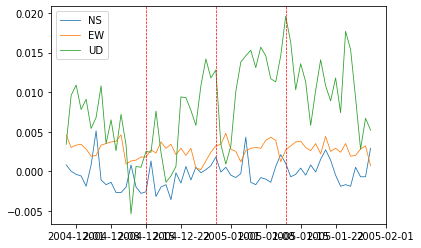

In [13]:
station021049 = GNSSdata[stationnames.index('021049')]
plt.plot(station021049.loc['2004-11-29':'2005-1-29'], linewidth=0.8)
plt.axvline(pd.to_datetime('2004-12-29'), linestyle='--', linewidth=0.7, color='r')
plt.axvline(pd.to_datetime('2004-12-15'), linestyle='--', linewidth=0.7, color='r')
plt.axvline(pd.to_datetime('2005-01-12'), linestyle='--', linewidth=0.7, color='r')
plt.legend(["NS", "EW", "UD"]);


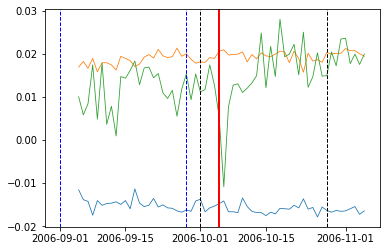

In [23]:
station021048 = GNSSdata[stationnames.index('021048')]
plt.plot(station021048.loc['2006-9-05':'2006-11-05'], linewidth=0.8)
plt.axvline(pd.to_datetime('2006-10-05'), linewidth=2, color='r')
plt.axvline(pd.to_datetime('2006-09-1'), linestyle='--', linewidth=1, color='b')
plt.axvline(pd.to_datetime('2006-09-28'), linestyle='--', linewidth=1, color='b')
plt.axvline(pd.to_datetime('2006-10-1'), linestyle='--', linewidth=1, color='black')
plt.axvline(pd.to_datetime('2006-10-28'), linestyle='--', linewidth=1, color='black')
# plt.legend(["NS", "EW", "UD"]);